# Zonal Statistics - categorical values

In [9]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
import rasterstats
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go


print(f'Rasterio : {rasterio.__version__}')
print(f'Rasterstats : {rasterstats.__version__}')

Rasterio : 1.0.8
Rasterstats : 0.14.0


## Set parameters

In [2]:
nodata_val = -10000

## Set directory

In [17]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

# Raster file
raster_file = f'{work_path}CLASSIF_OLD/Classif_RF_with_NDVI.tif'

# Vector file
vector_file  = f'{work_path}ROI/extent_roi_32631.shp'
vector_field = 'name'

# Look-up-table file
lut_file   = f'{work_path}LUT/LUT.xlsx'
code_field = 'CODE'
name_field = 'LC'  

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'
zonal_stat_csv  = f'{zonal_stat_path}zonal_stat_cat.csv'

Path(zonal_stat_path).mkdir(parents=True, exist_ok=True)

**Check if raster and vector file are intersecting**

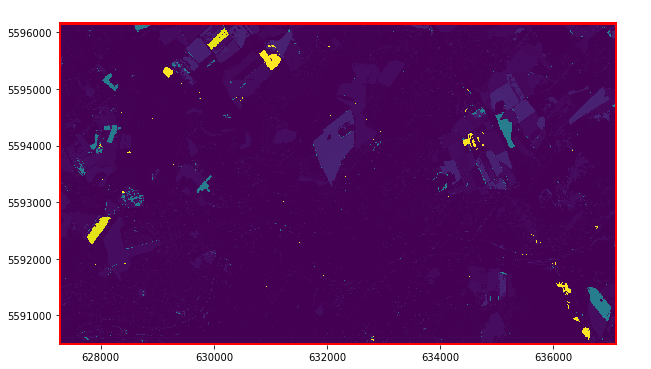

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot vector
gdf = gpd.read_file(vector_file)
gdf.plot(facecolor='none', edgecolor='red', linewidth = 4, ax=ax)

# Plot image
src = rasterio.open(raster_file, "r")
rasterio.plot.show(src, ax=ax)

plt.box(False)

## Build category map

rasterstats will report using the pixel values as keys. To associate the pixel values with their appropriate meaning, you can use a `category_map`

In [51]:
if os.path.isfile(lut_file):

    lut_df = pd.read_excel(lut_file)

    lut_df = lut_df[[code_field,name_field]].drop_duplicates()

    cmap = {}

    for index, row in lut_df.iterrows():

        nb   = row[code_field]
        name = row[name_field]

        cmap[nb] = f'{nb} - {name}'

else:
    cmap = None

print(cmap)

{6: '6 - Forest', 9: '9 - Trees', 12: '12 - Shrubland', 19: '19 - Urban', 20: '20 - Urban', 21: '21 - Water', 36: '36 - Spelt', 45: '45 - Flax (linseed) for seeds', 53: '53 - Lupine', 62: '62 - Grassland (temporary)', 73: '73 - Lucerne (alfalfa)', 91: '91 - Sugar beet', 201: '201 - Maize (for livestock)', 311: '311 - Common wheat (winter)', 321: '321 - Barley (winter)', 341: '341 - Oat (winter)', 342: '342 - Oat (spring)', 541: '541 - Mixed protein crops cereals or others (winter)', 542: '542 - Mixed protein crops cereals or others (spring)', 743: '743 - Other fodder', 821: '821 - Seeds multiplication for organic crops', 901: '901 - Potato (non-early)', 931: '931 - Peas', 959: '959 - Parsley (fresh consumption)', 4111: '4111 - Rapeseed (winter)', 9202: '9202 - Walnut tree', 9410: '9410 - Green beans', 9535: '9535 - Carrots (non-early) (fresh consumption)', 9741: '9741 - Fruit crops (multi-year) (low stem)', 9742: '9742 - Fruit crops (multi-year) (high stem)', 9812: '9812 - Chicory'}


## Check if raster and vector are projected to the same CRS

In [20]:
gdf = gpd.read_file(vector_file)
src = rasterio.open(raster_file, "r")

crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

CRS are the same : EPSG:32631 = EPSG:32631


## Compute zonal statistics with rasterstats - recommanded

In [57]:
dict_list = []

for i, row in gdf.iterrows():

    name  = row[vector_field]
    
    dict_freq = zonal_stats(row.geometry,
                            raster_file,
                            categorical=True,
                            category_map=cmap,
                            nodata=nodata_val)[0]

    dict_freq['name'] = name

    dict_list.append(dict_freq)

df = pd.DataFrame(dict_list).set_index('name')

df.to_csv(zonal_stat_csv)

print(f'CSV file was created : {zonal_stat_csv}')

df = df.transpose()
df = df.sort_values(by=df.columns[0], ascending=False)
display(df)

CSV file was created : /export/miro/ndeffense/LBRAT2104/GROUP_X/WORK/ZONAL_STATS/zonal_stat_cat.csv


name,ROI_wallonia
19 - Urban,161229
6 - Forest,131238
62 - Grassland (temporary),112938
201 - Maize (for livestock),43132
311 - Common wheat (winter),29821
321 - Barley (winter),17467
901 - Potato (non-early),14602
36 - Spelt,10015
21 - Water,7401
4111 - Rapeseed (winter),5446


## Compute zonal statistics with numpy - optional

In [27]:
src = rasterio.open(raster_file, "r")

for i in range(0,len(gdf))[0:10]:
    
    fid  = gdf.loc[i,vector_field]
    geom = gdf.geometry[[i]]
    print(f'ID : {fid}')

    # Crop the raster to the extent of the shape
    out_image, out_transform = rasterio.mask.mask(src, geom, crop=False)
    
    out_image = out_image[0]

    unique_elements, counts_elements = np.unique(out_image, return_counts=True)
    
    print(unique_elements)
    print(counts_elements)

src.close()


ID : ROI_wallonia
[-10000      6      9     12     19     20     21     36     45     62
     73     91    201    311    321    342    541    542    821    901
    931   4111   9410   9741   9742   9812]
[   986 131238     62    172 161229   2881   7401  10015   2500 112938
   4354   4016  43132  29821  17467   3175    753   1202   1942  14602
   3354   5446   1354    968    244    768]


## Plot histogram

In [59]:
fig = px.bar(df,
        x=df.index.str.slice(start=0, stop=20),
        y=df.columns[0])

fig.show()